In [243]:
import sys
sys.path.append('/home/t/tingli/tingli/pythoncode/')

import sqlutilpy
import dustmaps.sfd
SFD=dustmaps.sfd.SFDQuery()
import matplotlib.pyplot as plt
import sphdist
import sphere_rotate
import numpy as np
import matplotlib.pyplot as plt
import code_astro
from start_plot import *
plt.rcParams['figure.figsize']=[5,5]
def betw(x,x1,x2): return (x>x1)&(x<x2)
from idlplot import tvhist2d
from astropy import table

In [244]:
ra0,dec0= 209.3, 26.8
rad0 = 1.6

ra_cen,dec_cen=ra0+1, dec0+0.8

string = '''select release, brickid, brickname, objid, type, ra, dec, ebv, flux_g, flux_r, flux_z, flux_ivar_g,flux_ivar_r,flux_ivar_z \
from decals_dr9.main where q3c_radial_query(ra,dec,%f,%f,%f)'''%(ra_cen,dec_cen, rad0)
t = sqlutilpy.get(string, asDict = True) 
t = table.Table(t)
t['gmag'], t['rmag'], t['zmag'] = [22.5-2.5*np.log10(t['flux_'+_]) for _ in 'grz']

#correct for extinction using ebv from sfd98, from DES DR2
t['gmag0'] = t['gmag'] - t['ebv'] * 3.186
t['rmag0'] = t['rmag'] - t['ebv'] * 2.140
t['zmag0'] = t['zmag'] - t['ebv'] * 1.196
t['gmagerr'], t['rmagerr'], t['zmagerr'] = [2.5/np.log(10)*(np.sqrt(1./t['flux_ivar_'+_])/t['flux_'+_]) for _ in 'grz']

dm1 = code_astro.d2dm(46.5)
t['dist1'] = sphdist.sphdist(t['ra'],t['dec'],ra0,dec0)

dm2 = code_astro.d2dm(16.12)
ra2,dec2 = 211.364, 28.534
t['dist2'] = sphdist.sphdist(t['ra'],t['dec'],ra2,dec2)


/tmp/ipykernel_240376/675583019.py:10: RuntimeWarning: divide by zero encountered in log10
  t['gmag'], t['rmag'], t['zmag'] = [22.5-2.5*np.log10(t['flux_'+_]) for _ in 'grz']

/tmp/ipykernel_240376/675583019.py:10: RuntimeWarning: invalid value encountered in log10
  t['gmag'], t['rmag'], t['zmag'] = [22.5-2.5*np.log10(t['flux_'+_]) for _ in 'grz']

/tmp/ipykernel_240376/675583019.py:16: RuntimeWarning: divide by zero encountered in true_divide
  t['gmagerr'], t['rmagerr'], t['zmagerr'] = [2.5/np.log(10)*(np.sqrt(1./t['flux_ivar_'+_])/t['flux_'+_]) for _ in 'grz']



/tmp/ipykernel_240376/3587840203.py:2: RuntimeWarning: invalid value encountered in log10
  ydata = np.log10(t['rmagerr'])



Text(0, 0.5, 'log10(rmagerr)')

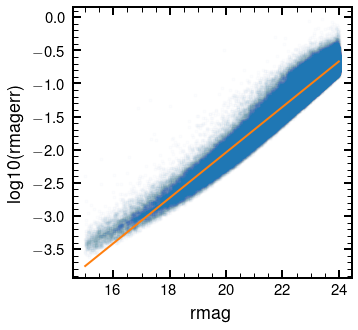

In [305]:
xdata = t['rmag']
ydata = np.log10(t['rmagerr'])
xnew = xdata[betw(xdata, 15,24)&betw(ydata,-4,0)]
ynew = ydata[betw(xdata, 15,24)&betw(ydata,-4,0)]

plt.plot(xnew, ynew,'.',alpha=0.01)

def log10_error_func(x, a, b):
    return a * x + b

from scipy.optimize import curve_fit
popt, pcov = curve_fit(log10_error_func, xnew, ynew)

xdata = np.linspace(15,24,100)
plt.plot(xdata, log10_error_func(xdata, *popt))
plt.xlabel('rmag')
plt.ylabel('log10(rmagerr)')

In [246]:
mem = table.Table.read('../data/Pace2022_UFDs/catalogs/bootes_3.dat', format='ascii')
mem = mem[mem['mem_fixed_complete']>0.5]

from astropy import table
from astropy.coordinates import SkyCoord
from astropy import units as u

c = SkyCoord(ra=mem['ra']*u.degree, dec=mem['dec']*u.degree)
catalog = SkyCoord(ra=t['ra']*u.degree, dec=t['dec']*u.degree)
match, d2d, d3d = c.match_to_catalog_sky(catalog)
mem = t[match][d2d<1*u.arcsec]

Text(0.5, 0, 'ra')

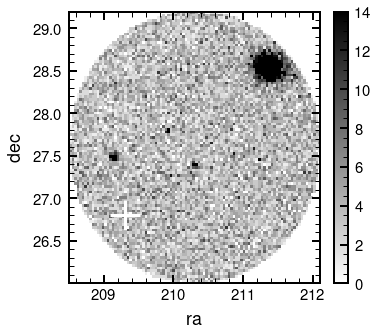

In [247]:
ind= (t['type'] == 'PSF') & (t['rmag']<22.5) & (t['rmag']>19)
tvhist2d(t['ra'][ind],t['dec'][ind],bar=True, vmaxfrac=.99)
plt.plot(ra0, dec0, '+w', mew=3,ms=30)
plt.ylabel('dec')
plt.xlabel('ra')

Text(0.5, 0, 'ra')

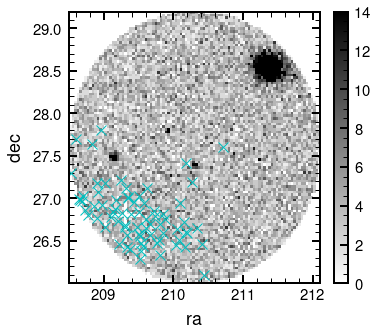

In [248]:
ind= (t['type'] == 'PSF') & (t['rmag']<22.5) & (t['rmag']>19)
tvhist2d(t['ra'][ind],t['dec'][ind],bar=True, vmaxfrac=.99)
plt.plot(ra0, dec0, '+w', mew=3,ms=30)
plt.plot(mem['ra'], mem['dec'],'xc', ms=10)
plt.ylabel('dec')
plt.xlabel('ra')

Text(0.5, 1.0, 'Boo3')

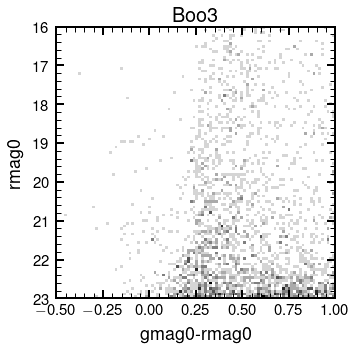

In [301]:
ind= (t['dist1']<0.5) & (t['type'] == 'PSF') 
tvhist2d(t['gmag0'][ind]-t['rmag0'][ind],t['rmag0'][ind],-0.5,1.0,23,16)
plt.ylabel('rmag0')
plt.xlabel('gmag0-rmag0')
plt.title('Boo3')

Text(0.5, 1.0, 'NGC5466')

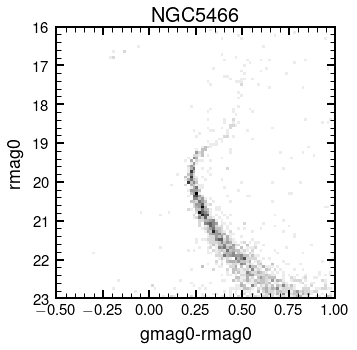

In [300]:
ind= (t['dist2']<0.2) & (t['dist2']>0.1) & (t['type'] == 'PSF') 
tvhist2d(t['gmag0'][ind]-t['rmag0'][ind],t['rmag0'][ind],-0.5,1.0,23,16)
plt.ylabel('rmag0')
plt.xlabel('gmag0-rmag0')
plt.title('NGC5466')

In [251]:
isofile_mp = '/home/t/tingli/tingli/data/isochrones/dotter/iso_a12.5_z0.00021.dat'
dotter_mp = np.loadtxt(isofile_mp)
dotter_g_mp = dotter_mp[:,6]
dotter_r_mp = dotter_mp[:,7]

isofile_mr = '/home/t/tingli/tingli/data/isochrones/dotter/iso_a10.0_z0.00108.dat'
dotter_mr = np.loadtxt(isofile_mr)
dotter_g_mr = dotter_mr[:,6]
dotter_r_mr = dotter_mr[:,7]

dm_m92_harris = 14.59
m92ebv = 0.023
m92ag = m92ebv * 3.184
m92ar = m92ebv * 2.130
m92_hb_r = np.array([17.3, 15.8, 15.38, 15.1, 15.05, 15.05])
m92_hb_col = np.array([-0.39, -0.3, -0.2, -0.0, 0.1,0.2])
m92_hb_g = m92_hb_r + m92_hb_col
des_m92_hb_g = m92_hb_g - 0.104 * (m92_hb_g - m92_hb_r) + 0.01
des_m92_hb_r = m92_hb_r - 0.102 * (m92_hb_g - m92_hb_r) + 0.02
des_m92_hb_g = des_m92_hb_g - m92ag - dm_m92_harris
des_m92_hb_r = des_m92_hb_r - m92ar - dm_m92_harris


Text(0.5, 1.0, 'Boo3')

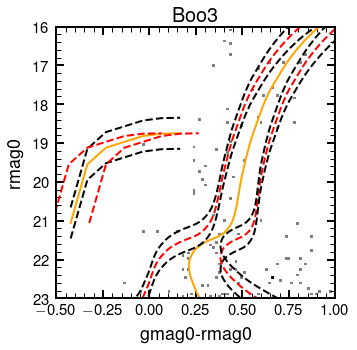

In [302]:
dotter_g, dotter_r = dotter_g_mp, dotter_r_mp #use the metal-poor isochrone
grw = np.sqrt(0.1**2 + (3*10**log10_error_func(dotter_r+dm1, *popt))**2)

ind= (t['dist1']<0.1) & (t['type'] == 'PSF') 
tvhist2d(t['gmag0'][ind]-t['rmag0'][ind],t['rmag0'][ind],-0.5,1.0,23,16)

plt.plot(dotter_g-dotter_r, dotter_r+dm1,lw=2,color='orange')
plt.plot(dotter_g-dotter_r+grw, dotter_r+dm1,'--r')
plt.plot(dotter_g-dotter_r-grw, dotter_r+dm1,'--r')
plt.plot(dotter_g-dotter_r+grw, dotter_r+dm1+0.3,'--k')
plt.plot(dotter_g-dotter_r-grw, dotter_r+dm1-0.3,'--k')
plt.plot(dotter_g-dotter_r+grw, dotter_r+dm1-0.3,'--k')
plt.plot(dotter_g-dotter_r-grw, dotter_r+dm1+0.3,'--k')

plt.plot(des_m92_hb_g-des_m92_hb_r, des_m92_hb_r+dm1, lw=2, color='orange')
plt.plot(des_m92_hb_g-des_m92_hb_r, des_m92_hb_r+dm1-0.4,'--k')
plt.plot(des_m92_hb_g-des_m92_hb_r, des_m92_hb_r+dm1+0.4,'--k')
plt.plot(des_m92_hb_g-des_m92_hb_r-0.1, des_m92_hb_r+dm1,'--r')
plt.plot(des_m92_hb_g-des_m92_hb_r+0.1, des_m92_hb_r+dm1,'--r')

plt.ylim(23, 16)
plt.xlim(-0.5,1)
plt.ylabel('rmag0')
plt.xlabel('gmag0-rmag0')
plt.title('Boo3')

In [253]:
# making actual selections/cuts -- CMD cut and color-color cut

# CMD cut for RGB
def cmd_selection(t, dm, dotter_g, dotter_r, gw=0.3):
    grw = np.sqrt(0.1**2 + (3*10**log10_error_func(dotter_r+dm, *popt))**2)
    gw = gw # RGB width in g
    rmin = 16
    rmax = 23
    grmin = -0.5
    grmax = 1.0
    magrange = (t['rmag'] > rmin) & (t['rmag'] < rmax) & (t['gmag0'] - t['rmag0'] < grmax) & (t['gmag0'] - t['rmag0'] > grmin)
    gr = t['gmag0'] - t['rmag0']
    grmax1 = np.interp(t['rmag0'], dotter_r[::-1] + dm, dotter_g[::-1] - dotter_r[::-1]+grw[::-1], left=np.nan, right=np.nan)
    grmax2 = np.interp(t['rmag0'], dotter_r[::-1] + dm + gw, dotter_g[::-1] - dotter_r[::-1]+grw[::-1], left=np.nan, right=np.nan)
    grmax3 = np.interp(t['rmag0'], dotter_r[::-1] + dm - gw, dotter_g[::-1] - dotter_r[::-1]+grw[::-1], left=np.nan, right=np.nan)
    grmax = np.max(np.array([grmax1, grmax2, grmax3]), axis=0)
    grmin1 = np.interp(t['rmag0'], dotter_r[::-1] + dm, dotter_g[::-1] - dotter_r[::-1]-grw[::-1], left=np.nan, right=np.nan)
    grmin2 = np.interp(t['rmag0'], dotter_r[::-1] + dm - gw, dotter_g[::-1] - dotter_r[::-1]-grw[::-1], left=np.nan, right=np.nan)
    grmin3 = np.interp(t['rmag0'], dotter_r[::-1] + dm + gw, dotter_g[::-1] - dotter_r[::-1]-grw[::-1], left=np.nan, right=np.nan)
    grmin = np.min(np.array([grmin1, grmin2, grmin3]), axis=0)
    colorsel = (gr < grmax) & (gr > grmin)
    colorrange = magrange & colorsel

    # CMD cut for BHB
    grw_bhb = 0.1 # BHB width in gr
    gw_bhb = gw+0.1  # BHB width in g
    grmin_bhb = -0.5
    grmax_bhb = 0.2
    magrange_bhb = (t['rmag'] > rmin) & (t['rmag'] < rmax) & (t['gmag0'] - t['rmag0'] < grmax_bhb) & (t['gmag0'] - t['rmag0'] > grmin_bhb)

    gr_bhb = np.interp(t['rmag0'], des_m92_hb_r[::-1] + dm , des_m92_hb_g[::-1] - des_m92_hb_r[::-1], left=np.nan, right=np.nan)
    rr_bhb = np.interp(t['gmag0'] - t['rmag0'], des_m92_hb_g - des_m92_hb_r, des_m92_hb_r + dm,left=np.nan, right=np.nan)
    del_color_cmd_bhb = t['gmag0'] - t['rmag0'] - gr_bhb
    del_g_cmd_bhb = t['rmag0'] - rr_bhb
    colorrange_bhb = magrange_bhb & ((abs(del_color_cmd_bhb) < grw_bhb) | (abs(del_g_cmd_bhb) < gw_bhb))

    colorrange = colorrange | colorrange_bhb
    
    return colorrange


/tmp/ipykernel_240376/3328859585.py:11: RuntimeWarning: invalid value encountered in subtract
  magrange = (t['rmag'] > rmin) & (t['rmag'] < rmax) & (t['gmag0'] - t['rmag0'] < grmax) & (t['gmag0'] - t['rmag0'] > grmin)

/tmp/ipykernel_240376/3328859585.py:12: RuntimeWarning: invalid value encountered in subtract
  gr = t['gmag0'] - t['rmag0']

/tmp/ipykernel_240376/3328859585.py:29: RuntimeWarning: invalid value encountered in subtract
  magrange_bhb = (t['rmag'] > rmin) & (t['rmag'] < rmax) & (t['gmag0'] - t['rmag0'] < grmax_bhb) & (t['gmag0'] - t['rmag0'] > grmin_bhb)

/tmp/ipykernel_240376/3328859585.py:32: RuntimeWarning: invalid value encountered in subtract
  rr_bhb = np.interp(t['gmag0'] - t['rmag0'], des_m92_hb_g - des_m92_hb_r, des_m92_hb_r + dm,left=np.nan, right=np.nan)

/tmp/ipykernel_240376/3328859585.py:33: RuntimeWarning: invalid value encountered in subtract
  del_color_cmd_bhb = t['gmag0'] - t['rmag0'] - gr_bhb



Text(0.5, 1.0, 'Boo3')

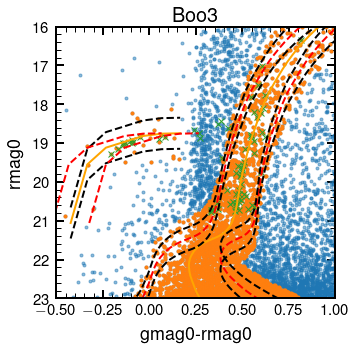

In [303]:
colorrange = cmd_selection(t, dm1, dotter_g, dotter_r, 0.6)

ind= (t['dist1']<0.9) & (t['type'] == 'PSF') 
plt.plot(t['gmag0'][ind]-t['rmag0'][ind],t['rmag0'][ind],'.', alpha=0.5)
plt.plot(t['gmag0'][ind&colorrange]-t['rmag0'][ind&colorrange],t['rmag0'][ind&colorrange], '.')

plt.plot(mem['gmag0']-mem['rmag0'], mem['rmag0'],'x')

plt.plot(dotter_g-dotter_r, dotter_r+dm1,lw=2,color='orange')
plt.plot(dotter_g-dotter_r+grw, dotter_r+dm1,'--r')
plt.plot(dotter_g-dotter_r-grw, dotter_r+dm1,'--r')
plt.plot(dotter_g-dotter_r+grw, dotter_r+dm1+0.3,'--k')
plt.plot(dotter_g-dotter_r-grw, dotter_r+dm1-0.3,'--k')
plt.plot(dotter_g-dotter_r+grw, dotter_r+dm1-0.3,'--k')
plt.plot(dotter_g-dotter_r-grw, dotter_r+dm1+0.3,'--k')

plt.plot(des_m92_hb_g-des_m92_hb_r, des_m92_hb_r+dm1, lw=2, color='orange')
plt.plot(des_m92_hb_g-des_m92_hb_r, des_m92_hb_r+dm1-0.4,'--k')
plt.plot(des_m92_hb_g-des_m92_hb_r, des_m92_hb_r+dm1+0.4,'--k')
plt.plot(des_m92_hb_g-des_m92_hb_r-0.1, des_m92_hb_r+dm1,'--r')
plt.plot(des_m92_hb_g-des_m92_hb_r+0.1, des_m92_hb_r+dm1,'--r')


plt.ylim(23, 16)
plt.xlim(-0.5,1)
plt.ylabel('rmag0')
plt.xlabel('gmag0-rmag0')
plt.title('Boo3')

/tmp/ipykernel_240376/3328859585.py:11: RuntimeWarning: invalid value encountered in subtract
  magrange = (t['rmag'] > rmin) & (t['rmag'] < rmax) & (t['gmag0'] - t['rmag0'] < grmax) & (t['gmag0'] - t['rmag0'] > grmin)

/tmp/ipykernel_240376/3328859585.py:12: RuntimeWarning: invalid value encountered in subtract
  gr = t['gmag0'] - t['rmag0']

/tmp/ipykernel_240376/3328859585.py:29: RuntimeWarning: invalid value encountered in subtract
  magrange_bhb = (t['rmag'] > rmin) & (t['rmag'] < rmax) & (t['gmag0'] - t['rmag0'] < grmax_bhb) & (t['gmag0'] - t['rmag0'] > grmin_bhb)

/tmp/ipykernel_240376/3328859585.py:32: RuntimeWarning: invalid value encountered in subtract
  rr_bhb = np.interp(t['gmag0'] - t['rmag0'], des_m92_hb_g - des_m92_hb_r, des_m92_hb_r + dm,left=np.nan, right=np.nan)

/tmp/ipykernel_240376/3328859585.py:33: RuntimeWarning: invalid value encountered in subtract
  del_color_cmd_bhb = t['gmag0'] - t['rmag0'] - gr_bhb



Text(0.5, 1.0, 'NGC5466')

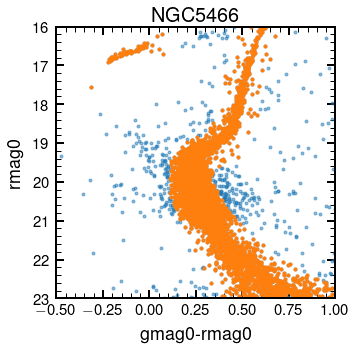

In [304]:
colorrange2 = cmd_selection(t, dm2, dotter_g, dotter_r)

ind= (t['dist2']<0.2) & (t['type'] == 'PSF') 
plt.plot(t['gmag0'][ind]-t['rmag0'][ind],t['rmag0'][ind],'.', alpha=0.5)

plt.plot(t['gmag0'][ind&colorrange2]-t['rmag0'][ind&colorrange2],t['rmag0'][ind&colorrange2], '.')

# plt.plot(dotter_g-dotter_r, dotter_r+dm2,lw=2,color='orange')
# plt.plot(dotter_g-dotter_r+grw, dotter_r+dm2,'--r')
# plt.plot(dotter_g-dotter_r-grw, dotter_r+dm2,'--r')
# plt.plot(dotter_g-dotter_r+grw, dotter_r+dm2+0.3,'--k')
# plt.plot(dotter_g-dotter_r-grw, dotter_r+dm2-0.3,'--k')
# plt.plot(dotter_g-dotter_r+grw, dotter_r+dm2-0.3,'--k')
# plt.plot(dotter_g-dotter_r-grw, dotter_r+dm2+0.3,'--k')

# plt.plot(des_m92_hb_g-des_m92_hb_r, des_m92_hb_r+dm2, lw=2, color='orange')
# plt.plot(des_m92_hb_g-des_m92_hb_r, des_m92_hb_r+dm2-0.4,'--k')
# plt.plot(des_m92_hb_g-des_m92_hb_r, des_m92_hb_r+dm2+0.4,'--k')
# plt.plot(des_m92_hb_g-des_m92_hb_r-0.1, des_m92_hb_r+dm2,'--r')
# plt.plot(des_m92_hb_g-des_m92_hb_r+0.1, des_m92_hb_r+dm2,'--r')


plt.ylim(23, 16)
plt.xlim(-0.5,1)
plt.ylabel('rmag0')
plt.xlabel('gmag0-rmag0')
plt.title('NGC5466')

Text(0.5, 0, 'ra')

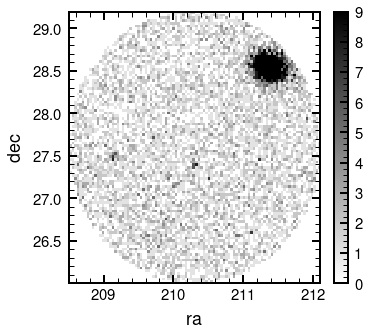

In [256]:
ind= (t['type'] == 'PSF') & (t['rmag']<22.5) & (t['rmag']>19) & (colorrange|colorrange2)
tvhist2d(t['ra'][ind],t['dec'][ind],bar=True, vmaxfrac=.99)
plt.ylabel('dec')
plt.xlabel('ra')

Text(0.5, 0, 'rmag')

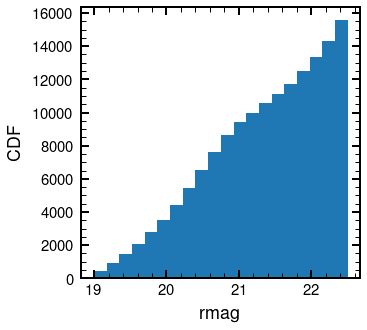

In [257]:
plt.hist(t['rmag'][ind],bins=20, cumulative=True)
plt.ylabel('CDF')
plt.xlabel('rmag')

Text(0.5, 0, 'ra')

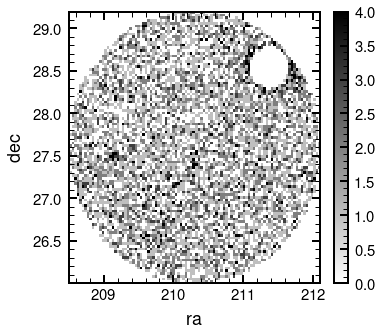

In [258]:
ind2 = (t['type'] == 'PSF') & (t['rmag']<22.5) & (t['rmag']>19) & (colorrange|colorrange2) & (t['dist2']>0.25)
tvhist2d(t['ra'][ind2],t['dec'][ind2],bar=True, vmaxfrac=.99)
plt.ylabel('dec')
plt.xlabel('ra')

Text(0.5, 0, 'rmag')

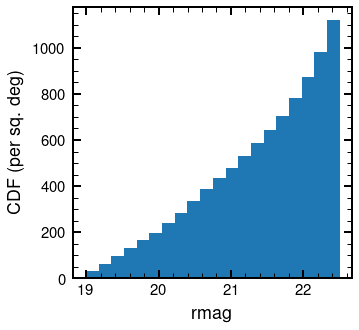

In [259]:
plt.hist(t['rmag'][ind2],bins=20, cumulative=True, weights=np.ones_like(t['rmag'][ind2])/(np.pi*rad0**2))
plt.ylabel('CDF (per sq. deg)')
plt.xlabel('rmag')

In [260]:
sqlgaia = 'select source_id, ra, dec, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error \
from gaia_edr3.gaia_source where q3c_radial_query(ra, dec, %f, %f, %f) and phot_g_mean_mag > 14'%(ra_cen,dec_cen, rad0)
gaia = sqlutilpy.get(sqlgaia, asDict = True)
gaia = table.Table(gaia)


In [261]:
t['idx'] = np.arange(len(t['ra']))

In [262]:
from astropy import table
from astropy.coordinates import SkyCoord
from astropy import units as u

c = SkyCoord(ra=gaia['ra']*u.degree, dec=gaia['dec']*u.degree)
catalog = SkyCoord(ra=t['ra']*u.degree, dec=t['dec']*u.degree)
match, d2d, d3d = c.match_to_catalog_sky(catalog)

In [296]:
plx_cut = gaia['parallax'] - 3 * gaia['parallax_error'] > 0.1 # distance > 2 kpc
pm_cut = (abs(gaia['pmra'])>7) | (abs(gaia['pmdec'])>7)

In [297]:
remove_list = t[match][(plx_cut|pm_cut)&(d2d<1*u.arcsec)]['idx']

In [298]:
ind2_gaiasel = np.array([i not in remove_list for i in t[ind2]['idx']])

Text(0.5, 0, 'rmag')

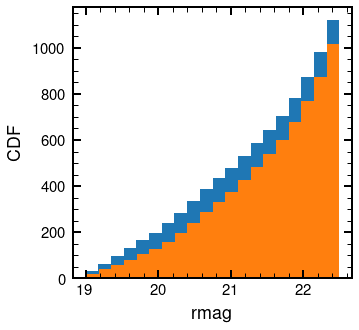

In [299]:
plt.hist(t['rmag'][ind2],bins=20, cumulative=True, weights=np.ones_like(t['rmag'][ind2])/(np.pi*rad0**2))
plt.hist(t['rmag'][ind2][ind2_gaiasel],bins=20, cumulative=True, weights=np.ones_like(t['rmag'][ind2][ind2_gaiasel])/(np.pi*rad0**2))
plt.ylabel('CDF')
plt.xlabel('rmag')

In [267]:
data = t

In [268]:
# Importing our libraries and packages required for the orbit
from galpy.orbit import Orbit
from galpy import potential
import numpy as np
import matplotlib.pyplot as plt
from galpy.util import conversion

# Importing potentials.
from galpy.potential import MWPotential2014,ChandrasekharDynamicalFrictionForce,HernquistPotential,MovingObjectPotential


In [237]:
## 6D Data and uncertainties from Dr. Andrew Pace's recent paper
sixD = [209.3, 26.8, 46.5, -1.176, -0.89, 197.5]
sigma = [0, 0, 2, 0.019, 0.015, 14]

sixD_2 = [211.364, 28.534, 16.12, -5.3423, -0.8223, 106.82]
sigma_2 = [0, 0, 0.15, 0.0245, 0.0242, 0.2]


pot = MWPotential2014
ro = 8.
vo = 220.
mo = conversion.mass_in_msol(ro=ro, vo=vo)
solarmotion = [-11.1, 12.24, 7.25]
# How many data points I want, taking into account the uncertainty
N_unc = 20
sixD_unc = np.random.normal(loc=sixD, scale=sigma, size = (N_unc,6))
sixD_unc_2 = np.random.normal(loc=sixD_2, scale=sigma_2, size = (N_unc,6))

In [238]:
# Initializing the orbits
o = Orbit(sixD, radec=True, solarmotion=solarmotion)
o_unc = Orbit(sixD_unc, radec=True, solarmotion=solarmotion)

# Initializing the orbits
o2 = Orbit(sixD_2, radec=True, solarmotion=solarmotion)
o_unc2 = Orbit(sixD_unc_2, radec=True, solarmotion=solarmotion)

In [239]:
# Initializing the timescale, so that I can integrate backwards 5Gyrs
t = 0.1
to = conversion.time_in_Gyr(ro=ro,vo=vo)
n = 101
ts= np.linspace(0.,-t/to,n)

(26.00039692034634, 29.199465183203912)

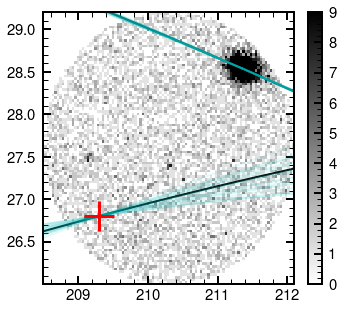

In [240]:
# Integrating the orbits
tvhist2d(data['ra'][ind],data['dec'][ind],bar=True, vmaxfrac=.99)

o.integrate(ts, pot=pot)
o_unc.integrate(ts, pot=pot)
o2.integrate(ts, pot=pot)
o_unc2.integrate(ts, pot=pot)
plt.plot(o.ra(ts), o.dec(ts),'k')
plt.plot(o_unc.ra(ts).T,o_unc.dec(ts).T,'-c',alpha=0.1)
plt.plot(o2.ra(ts), o2.dec(ts),'k')
plt.plot(o_unc2.ra(ts).T,o_unc2.dec(ts).T,'-c',alpha=0.1)

o.integrate(-ts, pot=pot)
o_unc.integrate(-ts, pot=pot)
o2.integrate(-ts, pot=pot)
o_unc2.integrate(-ts, pot=pot)
plt.plot(o.ra(-ts), o.dec(-ts),'k')
plt.plot(o_unc.ra(-ts).T,o_unc.dec(-ts).T,'-c',alpha=0.1)
plt.plot(o2.ra(-ts), o2.dec(-ts),'k')
plt.plot(o_unc2.ra(-ts).T,o_unc2.dec(-ts).T,'-c',alpha=0.1)
plt.plot(ra0, dec0, '+r', mew=3,ms=30)
plt.xlim(data['ra'].min(), data['ra'].max())
plt.ylim(data['dec'].min(), data['dec'].max())

(208.49464046027555, 212.10508261350824)

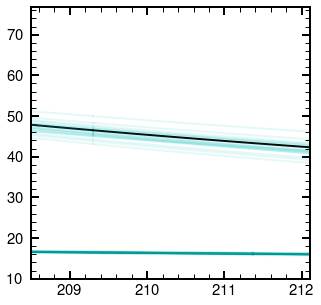

In [205]:
# Integrating the orbits
o.integrate(ts, pot=pot)
o_unc.integrate(ts, pot=pot)
o2.integrate(ts, pot=pot)
o_unc2.integrate(ts, pot=pot)
plt.plot(o.ra(ts), o.dist(ts),'k')
plt.plot(o_unc.ra(ts).T,o_unc.dist(ts).T,'-c',alpha=0.1)
plt.plot(o2.ra(ts), o2.dist(ts),'k')
plt.plot(o_unc2.ra(ts).T,o_unc2.dist(ts).T,'-c',alpha=0.1)

o.integrate(-ts, pot=pot)
o_unc.integrate(-ts, pot=pot)
o2.integrate(-ts, pot=pot)
o_unc2.integrate(-ts, pot=pot)
plt.plot(o.ra(-ts), o.dist(-ts),'k')
plt.plot(o_unc.ra(-ts).T,o_unc.dist(-ts).T,'-c',alpha=0.1)
plt.plot(o2.ra(-ts), o2.dist(-ts),'k')
plt.plot(o_unc2.ra(-ts).T,o_unc2.dist(-ts).T,'-c',alpha=0.1)
plt.xlim(data['ra'].min(), data['ra'].max())
#plt.ylim(dist-1, dist+1)

(208.49464046027555, 212.10508261350824)

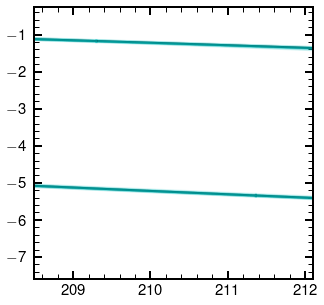

In [206]:
# Integrating the orbits
o.integrate(ts, pot=pot)
o_unc.integrate(ts, pot=pot)
o2.integrate(ts, pot=pot)
o_unc2.integrate(ts, pot=pot)
plt.plot(o.ra(ts), o.pmra(ts),'k')
plt.plot(o_unc.ra(ts).T,o_unc.pmra(ts).T,'-c',alpha=0.1)
plt.plot(o2.ra(ts), o2.pmra(ts),'k')
plt.plot(o_unc2.ra(ts).T,o_unc2.pmra(ts).T,'-c',alpha=0.1)

o.integrate(-ts, pot=pot)
o_unc.integrate(-ts, pot=pot)
o2.integrate(-ts, pot=pot)
o_unc2.integrate(-ts, pot=pot)
plt.plot(o.ra(-ts), o.pmra(-ts),'k')
plt.plot(o_unc.ra(-ts).T,o_unc.pmra(-ts).T,'-c',alpha=0.1)
plt.plot(o2.ra(-ts), o2.pmra(-ts),'k')
plt.plot(o_unc2.ra(-ts).T,o_unc2.pmra(-ts).T,'-c',alpha=0.1)
plt.xlim(data['ra'].min(), data['ra'].max())
#plt.ylim(dist-1, dist+1)

(208.49464046027555, 212.10508261350824)

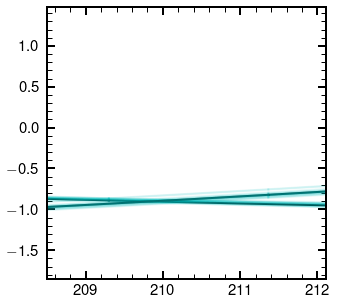

In [210]:
# Integrating the orbits
o.integrate(ts, pot=pot)
o_unc.integrate(ts, pot=pot)
o2.integrate(ts, pot=pot)
o_unc2.integrate(ts, pot=pot)
plt.plot(o.ra(ts), o.pmdec(ts),'k')
plt.plot(o_unc.ra(ts).T,o_unc.pmdec(ts).T,'-c',alpha=0.1)
plt.plot(o2.ra(ts), o2.pmdec(ts),'k')
plt.plot(o_unc2.ra(ts).T,o_unc2.pmdec(ts).T,'-c',alpha=0.1)

o.integrate(-ts, pot=pot)
o_unc.integrate(-ts, pot=pot)
o2.integrate(-ts, pot=pot)
o_unc2.integrate(-ts, pot=pot)
plt.plot(o.ra(-ts), o.pmdec(-ts),'k')
plt.plot(o_unc.ra(-ts).T,o_unc.pmdec(-ts).T,'-c',alpha=0.1)
plt.plot(o2.ra(-ts), o2.pmdec(-ts),'k')
plt.plot(o_unc2.ra(-ts).T,o_unc2.pmdec(-ts).T,'-c',alpha=0.1)
plt.xlim(data['ra'].min(), data['ra'].max())
#plt.ylim(dist-1, dist+1)